In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from shared.utility import get_model_file, limit_gpu_memory
from shared.metrics import f1_score

limit_gpu_memory()

/home/tim/workspace/dlbook/shared/plot_history.py:12: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib64/python3.4/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib64/python3.4/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tim/venvs/dlb/lib64/python3.4/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tim/venvs/dlb/lib64/python3.4/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tim/venvs/dlb/lib64/python3.4/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/tim/venvs/dlb/lib64

## Setup some constants

In [2]:
PROJECT_NAME="dogs_cats"
INPUT_DIR="data/{}".format(PROJECT_NAME)
OUTPUT_DIR="output/{}".format(PROJECT_NAME)
TEST_DIR = os.path.join(INPUT_DIR, "test")

## Check available models

In [3]:
!ls output/dogs_cats/*ex05_02*

output/dogs_cats/model-ex05_02-2019.01.27.14.36.31.h5


## Load Model

In [5]:
MODEL_TS = "2019.01.27.14.36.31" #timestamp from cell above of model we want
MODEL_FILE = get_model_file(OUTPUT_DIR, fname="ex05_02", ts=MODEL_TS)
model = load_model(MODEL_FILE, custom_objects={'f1_score': f1_score})
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

## Pick and image and plot it

(1, 150, 150, 3)


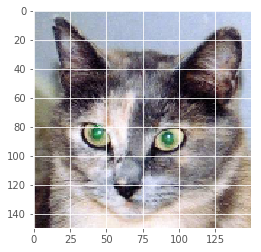

In [6]:
IMG_PATH = os.path.join(TEST_DIR, 'cats', 'cat.1700.jpg')

img = image.load_img(IMG_PATH, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)
plt.imshow(img_tensor[0])
plt.show()

## Capture activations

In [7]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

## Run capture on our test image

In [8]:
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


## Plot activation channel 4

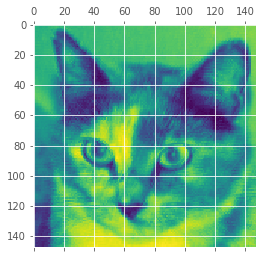

In [9]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

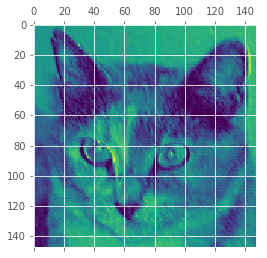

In [10]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

processing layer: conv2d_1
    shape: (1, 148, 148, 32)
     display_grip.shape: (296, 2368)
     ncols: 2 scale: 0.006756756756756757
processing layer: max_pooling2d_1
    shape: (1, 74, 74, 32)
     display_grip.shape: (148, 1184)
     ncols: 2 scale: 0.013513513513513514
processing layer: conv2d_2
    shape: (1, 72, 72, 64)
     display_grip.shape: (288, 1152)
     ncols: 4 scale: 0.013888888888888888
processing layer: max_pooling2d_2
    shape: (1, 36, 36, 64)
     display_grip.shape: (144, 576)
     ncols: 4 scale: 0.027777777777777776
processing layer: conv2d_3
    shape: (1, 34, 34, 128)
     display_grip.shape: (272, 544)
     ncols: 8 scale: 0.029411764705882353
processing layer: max_pooling2d_3
    shape: (1, 17, 17, 128)
     display_grip.shape: (136, 272)
     ncols: 8 scale: 0.058823529411764705
processing layer: conv2d_4
    shape: (1, 15, 15, 128)
     display_grip.shape: (120, 240)
     ncols: 8 scale: 0.06666666666666667
processing layer: max_pooling2d_4
    shape: (1,

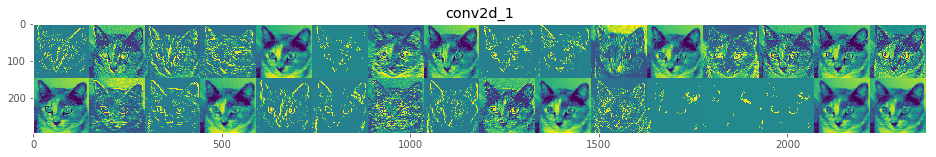

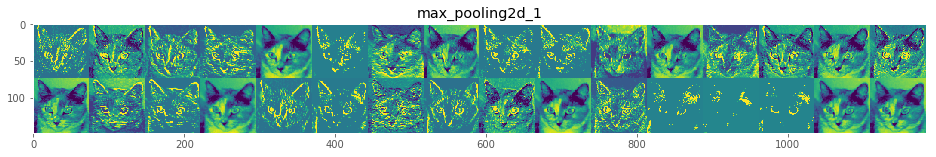

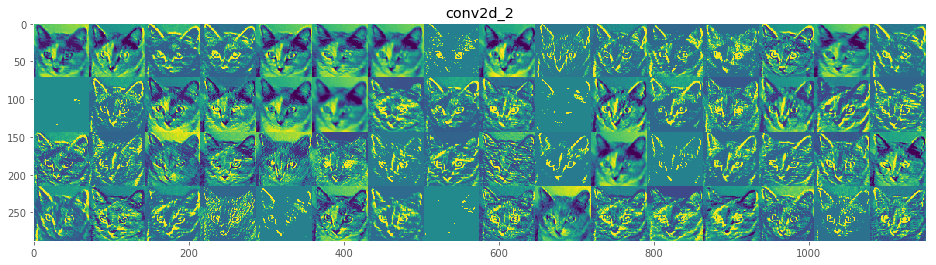

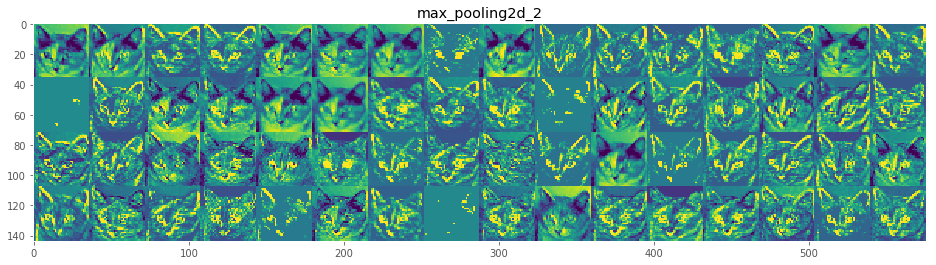

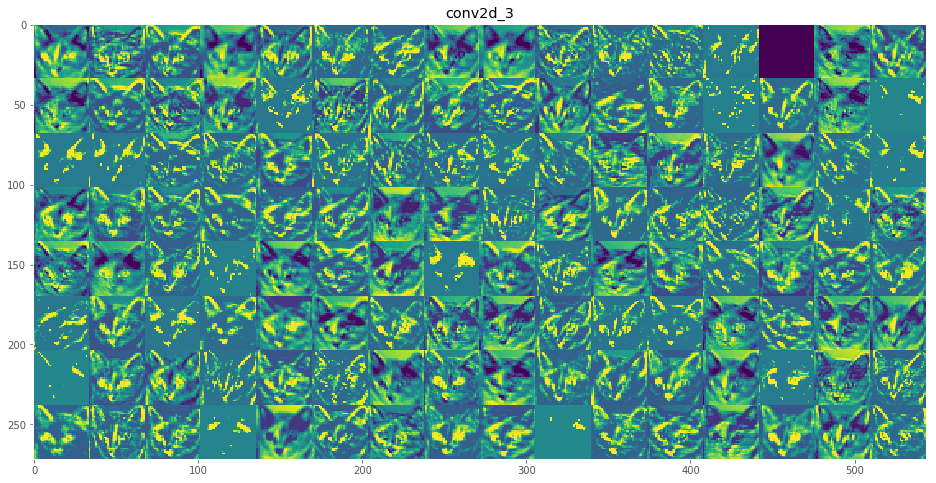

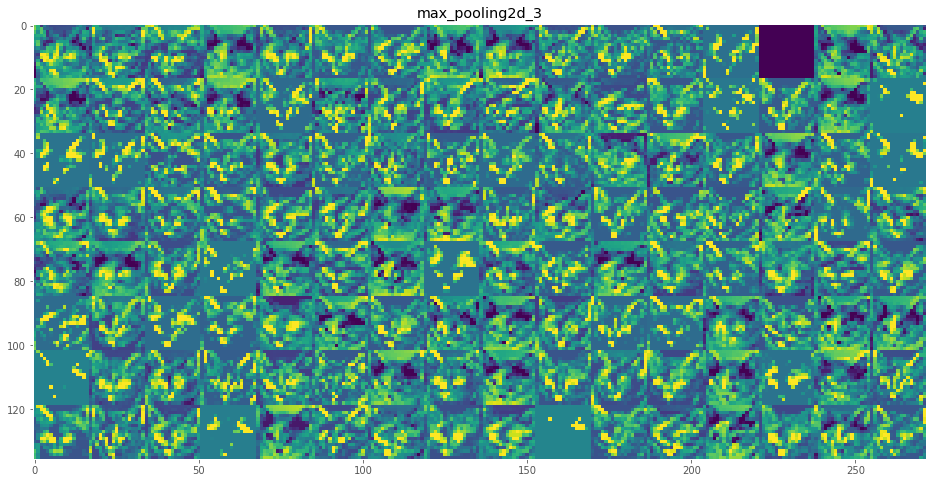

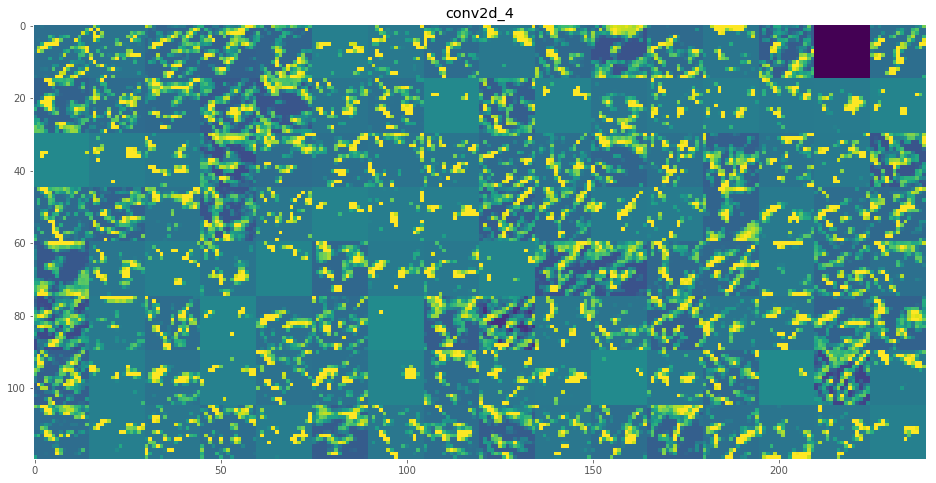

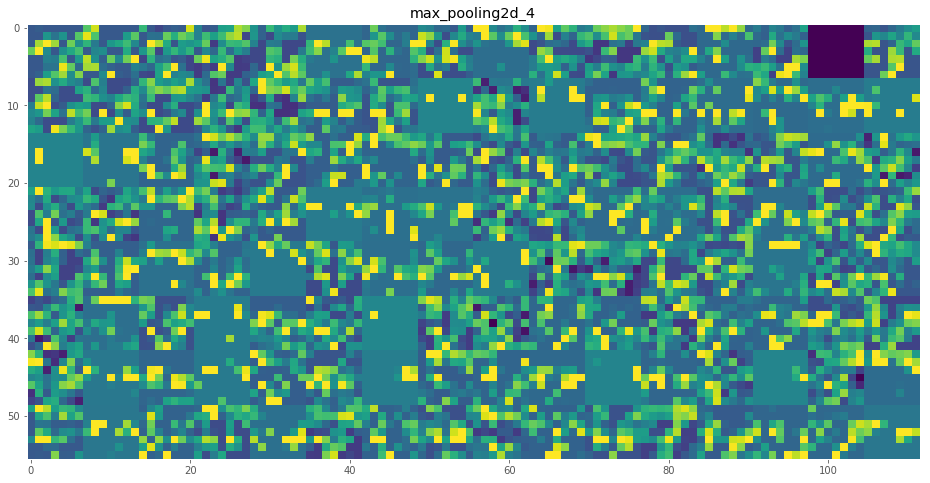

In [20]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
IMAGES_PER_ROW = 16

for layer_name, layer_activation in zip(layer_names, activations):
    print("processing layer: {}".format(layer_name))
    print("    shape: {}".format(layer_activation.shape))
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // IMAGES_PER_ROW
    display_grid = np.zeros((size * n_cols, IMAGES_PER_ROW * size))
    print("     display_grip.shape: {}".format(display_grid.shape))
    
    for col in range(n_cols):
        for row in range(IMAGES_PER_ROW):
            channel_image = layer_activation[0, :, :, col * IMAGES_PER_ROW + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                        row * size : (row + 1) * size] = channel_image
            
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], 
                       scale * display_grid.shape[0]))
    print("     ncols: {} scale: {}".format(n_cols, scale))
    
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
            
    
    